# 数据聚合与分组计算

对数据集进行**分组**并对各组应用一个**函数**(无论是聚合还是转换),这是数据分析工作中的重要环节。在将数据集准备好之后,通常的任务就是**计算分组统计**或**生成透视表**。pandas提供了一个灵活高效的**gruopby**功能,它使你能以一种自然的方式对数据集进行**切片**、**切块**、**摘要**等操作。

关系型数据库和SQL(Structured Query Language,结构化查询语言)能够如此流行的原因之一就是其能够方便地对数据进行连接、过滤、转换和聚合。但是,像SQL这样的查询语言所能执行的分组运算的种类很有限。在本章中你将会看到,由于Python和pandas强大的表达能力,我们可以执行复杂得多的分组运算(利用任何可以接受pandas对象或NumPy数组的函数)。

在本章中,你将会学到:
* 根据一个或多个键(可以是函数、数组或DataFrame列名)拆分pandas对象。
* 计算分组摘要统计,如计数、平均值、标准差,或用户自定义函数。
* 对DataFrame的列应用各种各样的函数。
* 应用组内转换或其他运算,如规格化、线性回归、排名或选取子集等。
* 计算透视表或交叉表。
* 执行分位数分析以及其他分组分析。

In [1]:
import numpy as np

import pandas as pd
from pandas import Series
from pandas import DataFrame

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

/home/helong/anaconda2/envs/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def print_gb(gb):
    for n,g in gb:
        print n
        print g
        print '\n'

## GroupBy技术

### 分组运算（split-apply-combine）

分组运算（split-apply-combine）：
* 拆分：
    * 通过一个或多个键对原数据进行拆分到不同组中；
* 应用：
    * 在不同组上应用函数计算得到结果；
* 合并：
    * 将结果合并到最终的结果对象中；

下图很好的展示了该过程：
![分组计算](https://github.com/NemoHoHaloAi/machine_learning/blob/master/python%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90/images/%E5%88%86%E7%BB%84%E8%AE%A1%E7%AE%97.png?raw=true)

### 分组键的可取情况

分组键可以有多种形式,且类型不必相同:
* 列表或数组,其长度与待分组的轴一样。
* 表示DataFrame某个列名的值。
* 字典或Series,给出待分组轴上的值与分组名之间的对应关系。
* 函数,用于处理轴索引或索引中的各个标签。
**注意**：后三种本质上是第一种的快捷方式，通过各种方式获取用于拆分对象的值，因此可以将这四种方式看做是如何获取用于拆分对象的值的四种方式即可，第一种是直接使用数组，第二种是取列名，第三种是映射关系，第四种是靠返回值；

注意：不管分组时表面上使用的是什么，最终都会转换成一个用于对应数据应该处于哪个分组的数组，数组上每个值，决定了相应位置的数据应该属于哪个分组；

### 分组示例

#### 使用Series做分组键 -- 例如df['key1']

In [3]:
df = DataFrame({'data1':[10,20,30,40,50],'data2':[40,50,60,70,80],
                'key1':['a','b','a','b','a'],'key2':['c','d','d','c','c']},
              index=['HL','LM','BL','JK','MP'])
df

,data1,data2,key1,key2
HL,10,40,a,c
LM,20,50,b,d
BL,30,60,a,d
JK,40,70,b,c
MP,50,80,a,c


In [4]:
# 对data1列数据按照key1分组并聚合计算平均值
df['data1'].groupby(df['key1']).mean() # 生成Series索引为key1的唯一值

key1
a    30
b    30
Name: data1, dtype: int64

In [5]:
# 对data1按照key1，key2分组并计算平均值
df['data1'].groupby([df['key1'],df['key2']]).mean() # 生成Series索引为key1，key2的唯一键组合

key1  key2
a     c       30
      d       30
b     c       40
      d       20
Name: data1, dtype: int64

#### 任意数组做分组键 -- 数组每个值对应同位置行的值，也就是强行有一种映射关系

In [6]:
arr = np.array(['aa','bb','cc','aa','cc'])
df['data1'].groupby(arr).mean()

aa    25
bb    20
cc    40
Name: data1, dtype: int64

#### 将列名(可以是字符串、数字或其他Python对象)用作分组键 -- 默认丢弃非数值组

In [7]:
df.groupby('key1').mean() # 使用列名作为分组键时不能针对某一列（Series）分组了就，因为Series没有该列名

,data1,data2
key1,,
a,30,60
b,30,60


#### groupby的size

In [8]:
df.groupby('key2').size()

key2
c    3
d    2
dtype: int64

### 对分组进行迭代

GroupBy对象支持迭代,可以产生一组二元元组(由分组名和数据块组成)。

#### 单键分组迭代

In [9]:
for name,group in df.groupby('key1'):
    print name
    print group
    print '\n'

a
    data1  data2 key1 key2
HL     10     40    a    c
BL     30     60    a    d
MP     50     80    a    c


b
    data1  data2 key1 key2
LM     20     50    b    d
JK     40     70    b    c




#### 多键分组迭代

In [10]:
for names,group in df.groupby(['key1','key2']):
    print names
    print group
    print '\n'

('a', 'c')
    data1  data2 key1 key2
HL     10     40    a    c
MP     50     80    a    c


('a', 'd')
    data1  data2 key1 key2
BL     30     60    a    d


('b', 'c')
    data1  data2 key1 key2
JK     40     70    b    c


('b', 'd')
    data1  data2 key1 key2
LM     20     50    b    d




#### 将分组结果转换为字典

In [11]:
group_dict = dict(list(df.groupby(['key1','key2'])))
for key in group_dict:
    print key
    print group_dict[key]
    print '\n'

('b', 'c')
    data1  data2 key1 key2
JK     40     70    b    c


('a', 'd')
    data1  data2 key1 key2
BL     30     60    a    d


('a', 'c')
    data1  data2 key1 key2
HL     10     40    a    c
MP     50     80    a    c


('b', 'd')
    data1  data2 key1 key2
LM     20     50    b    d




#### 在索引上分组 -- 指定axis=0

In [12]:
for name,group in df.groupby(['A','A','B','B','B'], axis=0):
    print name
    print group
    print '\n'

A
    data1  data2 key1 key2
HL     10     40    a    c
LM     20     50    b    d


B
    data1  data2 key1 key2
BL     30     60    a    d
JK     40     70    b    c
MP     50     80    a    c




### 选取一个或一组列 -- 可以直接对指定的列进行分组，或对分组结果取对应列

#### 对指定的列进行分组

In [13]:
df['data2'].groupby([df['key1'],df['key2']]).mean()

key1  key2
a     c       60
      d       60
b     c       70
      d       50
Name: data2, dtype: int64

#### 对分组结果取指定列 -- 这种方式是上一种方式的语法糖

In [14]:
df.groupby(['key1', 'key2'])['data2'].mean()

key1  key2
a     c       60
      d       60
b     c       70
      d       50
Name: data2, dtype: int64

#### 注意下述两种写法的不同之处

In [15]:
df.groupby(['key1'])['data2'].mean()

key1
a    60
b    60
Name: data2, dtype: int64

In [16]:
df.groupby(['key1'])[['data2']].mean()

,data2
key1,
a,60
b,60


比较：
* \['data2'\]：
    * 结果为Series；
    * Name属性为对应取的列名；
    * **DataFrame['列名']**得到的是对应列的**Series**形式；
* \[\['data2'\]\]：
    * 结果为DataFrame；
    * 索引为分组键，列为对应取的列名；
    * **DataFrame[['列名']]**得到的是对应列+原索引组成的**DataFrame**形式；

In [17]:
df['key1'] # 获取原索引+该列数据的Series

HL    a
LM    b
BL    a
JK    b
MP    a
Name: key1, dtype: object

In [18]:
df[['key1']] # 获取原索引+该列的DataFrame

,key1
HL,a
LM,b
BL,a
JK,b
MP,a


### 通过字典或Series进行分组

In [19]:
df = DataFrame(np.random.randn(5,5),
              columns=['a','b','c','d','e'],
              index=['01','02','03','04','05'])
df.ix[1:4,1:4] = np.nan # 设置几个nan值
df

/home/helong/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,a,b,c,d,e
01,0.662247,0.860610,0.203957,-0.713522,0.428074
02,1.267209,NaN,NaN,NaN,-0.321376
03,1.481049,NaN,NaN,NaN,-0.323719
04,-0.145378,NaN,NaN,NaN,0.808353
05,-0.652375,1.121243,-0.196689,-0.015549,-1.819802


#### 通过字典分组

In [20]:
dict_col = {'a':'A','b':'B','c':'A','d':'A','e':'B'}
df.groupby(dict_col, axis=1).mean()# 指定分组关系，等价于df.groupby(['A','B','A','A','B'], axis=1).mean()

,A,B
01,0.050894,0.644342
02,1.267209,-0.321376
03,1.481049,-0.323719
04,-0.145378,0.808353
05,-0.288205,-0.349280


#### 通过Series分组 -- 

In [21]:
series_col = Series({'a':'A','b':'B','c':'A','d':'A','e':'B'}) # 长度不一定要一致的
df.groupby(series_col, axis=1).mean()

,A,B
01,0.050894,0.644342
02,1.267209,-0.321376
03,1.481049,-0.323719
04,-0.145378,0.808353
05,-0.288205,-0.349280


### 通过函数分组

相较于字典或Series,Python函数在定义分组映射关系时可以更
有创意且更为抽象。任何被当做分组键的函数都会在各个索引值上被
调用一次,其返回值就会被用作分组名称。

#### 纯函数分组

In [22]:
df = DataFrame({'grade':[67,54,47,82,66]}, index=['Jack Jr.','Murphy','Mark Jr.','Lily','John Jr.'])
df.groupby(lambda name:'Jr.' in name).mean() # 根据名称中是否存在Jr.进行分组统计分数平均值

,grade
False,68
True,60


#### 函数混合其他分组 -- 先使用函数分为True，False两组，再根据数组继续细分

In [23]:
df.groupby([lambda name:'Jr.' in name,['1','2','2','1','2']]).mean() # 函数混合数组

grade
False 1   82.0
      2   54.0
True  1   67.0
      2   56.5

### 根据索引级别分组 -- 直接通过level参数指定分组级别即可

In [24]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],[1, 3, 5, 1, 3]], names=['cty', 'tenor'])
df = DataFrame(np.random.randn(4, 5), columns=columns)
df

cty          US                            JP          
tenor         1         3         5         1         3
0      1.168066 -0.280242  0.159205 -2.375300 -0.615187
1      1.251817  0.376484  0.079091 -0.552057  1.616157
2     -0.292800 -0.014396  0.554007 -0.831250  0.805926
3      0.387663 -1.236364 -0.280813  0.047043 -1.423120

In [25]:
df.groupby(level='cty', axis=1).mean() # 按照cty分组，也就是最外层索引

cty,JP,US
0,-1.495243,0.349010
1,0.532050,0.569131
2,-0.012662,0.082270
3,-0.688039,-0.376505


In [26]:
df.groupby(level=1, axis=1).mean() # 按照最内层索引分组

tenor,1,3,5
0,-0.603617,-0.447714,0.159205
1,0.349880,0.996321,0.079091
2,-0.562025,0.395765,0.554007
3,0.217353,-1.329742,-0.280813


## 数据聚合

对于**聚合**,我指的是任何能够从**数组**产生**标量值**的**数据转换**过
程。之前的例子中我已经用过一些,比如mean、count、min以及sum等。
你可能想知道在GroupBy对象上调用mean()时究竟发生了什么。许多
常见的聚合运算都有就地计算数据集统计信息的优化
实现。然而,并不是只能使用这些方法。你可以使用**自己发明**的**聚合运
算**,还可以调用分组对象上**已经定义**好的任何**方法**。

### 一般聚合方法

In [27]:
gb = DataFrame({'data1':[10,20,30,40,50],'data2':[40,50,60,70,80],
                'key1':['a','b','a','b','a'],'key2':['c','d','d','c','c']},
              index=['HL','LM','BL','JK','MP']).groupby('key1')

for name,group in gb:
    print name
    print group
    print '\n'

a
    data1  data2 key1 key2
HL     10     40    a    c
BL     30     60    a    d
MP     50     80    a    c


b
    data1  data2 key1 key2
LM     20     50    b    d
JK     40     70    b    c




#### quantile -- 分位数 默认丢弃非数值列

In [28]:
gb.quantile(0.9)

0.9,data1,data2
key1,,
a,46.0,76.0
b,38.0,68.0


#### 使用自定义聚合方法 -- agg(callable, string, dictionary, or list of string/callables)

In [29]:
def func(x):
    return x.max() - x.min()

gb.agg(func) # 应用于每一个分组

,data1,data2
key1,,
a,40,40
b,20,20


注意: 可能你已经注意到了,自定义聚合函数要比内置的那些
经过优化的函数慢得多。这是因为在构造**中间分组数据块**时存在非常
大的开销(**函数调用**、**数据重排**等)。

#### GroupBy内置的可用聚合方法

* count：分组中非NaN的值的个数；
* sum：分组中非NaN值的和；
* mean：分组中非NaN值的平均值；
* median：分组中非NaN值的算数中位数；
* std,var：分组中非NaN值的无偏（分母为n-1，矫正过）标准差/方差；
* min,max：分组中非NaN值的最小/最大值；
* prod：分组中非NaN值的积；
* first,last：分组第一个/最后一个非NaN的值；

### 对比agg，aggregate，apply

In [30]:
def test(x):
    print type(x)
    print x
    print '\n'
    return 2

#### agg

In [31]:
gb.agg(test)

<class 'pandas.core.series.Series'>
HL    10
BL    30
MP    50
Name: data1, dtype: int64


<class 'pandas.core.series.Series'>
LM    20
JK    40
Name: data1, dtype: int64


<class 'pandas.core.series.Series'>
HL    40
BL    60
MP    80
Name: data2, dtype: int64


<class 'pandas.core.series.Series'>
LM    50
JK    70
Name: data2, dtype: int64


<class 'pandas.core.series.Series'>
HL    c
BL    d
MP    c
Name: key2, dtype: object


<class 'pandas.core.series.Series'>
LM    d
JK    c
Name: key2, dtype: object




,data1,data2,key2
key1,,,
a,2,2,2
b,2,2,2


agg：
* 作用于每一组的每一个列（也就是Series）上；
* 结果是聚合结果组成的DataFrame

#### aggregate

In [32]:
gb.aggregate(test)

<class 'pandas.core.series.Series'>
HL    10
BL    30
MP    50
Name: data1, dtype: int64


<class 'pandas.core.series.Series'>
LM    20
JK    40
Name: data1, dtype: int64


<class 'pandas.core.series.Series'>
HL    40
BL    60
MP    80
Name: data2, dtype: int64


<class 'pandas.core.series.Series'>
LM    50
JK    70
Name: data2, dtype: int64


<class 'pandas.core.series.Series'>
HL    c
BL    d
MP    c
Name: key2, dtype: object


<class 'pandas.core.series.Series'>
LM    d
JK    c
Name: key2, dtype: object




,data1,data2,key2
key1,,,
a,2,2,2
b,2,2,2


同上

#### apply

In [33]:
gb.apply(test)

<class 'pandas.core.frame.DataFrame'>
    data1  data2 key2
HL     10     40    c
BL     30     60    d
MP     50     80    c


<class 'pandas.core.frame.DataFrame'>
    data1  data2 key2
HL     10     40    c
BL     30     60    d
MP     50     80    c


<class 'pandas.core.frame.DataFrame'>
    data1  data2 key2
LM     20     50    d
JK     40     70    c




key1
a    2
b    2
dtype: int64

In [34]:
gb.apply(lambda x:x.min())

,data1,data2,key2
key1,,,
a,10,40,c
b,20,50,c


apply：
* 作用于每一个分组；
* 聚合结果是每一个分组的结果组成的Series；

但是为什么有三次循环呢？？

#### 总结

apply是作用于每一个分组上的，而agg，aggregate是作用于每一个分组的每一列上；

### 小费示例

In [35]:
# step1 加载数据
tips = pd.read_csv('https://raw.githubusercontent.com/NemoHoHaloAi/pydata-book/2nd-edition/examples/tips.csv')
tips.head(5)

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Sun,Dinner,2
4,24.59,3.61,No,Sun,Dinner,4


In [36]:
# step2 增加小费所占比例列
tips['tip_proportion'] = tips['tip'] / tips['total_bill']
tips.head(5)

,total_bill,tip,smoker,day,time,size,tip_proportion
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [37]:
# step3 增加sex列，这个主要因为目前的数据没有这一列。。。
tips['sex'] = ['male' if x%3==0 else 'female' for x in np.arange(len(tips))]
tips.head(5)

,total_bill,tip,smoker,day,time,size,tip_proportion,sex
0,16.99,1.01,No,Sun,Dinner,2,0.059447,male
1,10.34,1.66,No,Sun,Dinner,3,0.160542,female
2,21.01,3.50,No,Sun,Dinner,3,0.166587,female
3,23.68,3.31,No,Sun,Dinner,2,0.139780,male
4,24.59,3.61,No,Sun,Dinner,4,0.146808,female


### 面向列的多函数应用

对Series或DataFrame列的**聚合运算**其实就是使用
**aggregate**(使用自定义函数)或调用诸如**mean**、**std**之类的方法。然而,
你可能希望对**不同的列**使用**不同的聚合函数**,或**一次应用多个函数**。

In [38]:
gb_sex_smoker = tips.groupby(['sex','smoker'])
print_gb(gb_sex_smoker)

('female', 'No')
     total_bill   tip smoker   day    time  size  tip_proportion     sex
1         10.34  1.66     No   Sun  Dinner     3        0.160542  female
2         21.01  3.50     No   Sun  Dinner     3        0.166587  female
4         24.59  3.61     No   Sun  Dinner     4        0.146808  female
5         25.29  4.71     No   Sun  Dinner     4        0.186240  female
7         26.88  3.12     No   Sun  Dinner     4        0.116071  female
8         15.04  1.96     No   Sun  Dinner     2        0.130319  female
10        10.27  1.71     No   Sun  Dinner     2        0.166504  female
11        35.26  5.00     No   Sun  Dinner     4        0.141804  female
13        18.43  3.00     No   Sun  Dinner     4        0.162778  female
14        14.83  3.02     No   Sun  Dinner     2        0.203641  female
16        10.33  1.67     No   Sun  Dinner     3        0.161665  female
17        16.29  3.71     No   Sun  Dinner     3        0.227747  female
19        20.65  3.35     No   Sat

#### 应用一个函数

In [39]:
gb_sex_smoker['tip_proportion'].agg('mean') # 对于tips_proportion进行平均值聚合计算

sex     smoker
female  No        0.162939
        Yes       0.171521
male    No        0.151813
        Yes       0.148060
Name: tip_proportion, dtype: float64

#### 应用多个函数

In [40]:
def test(x):
    return x.max() - x.min()

gb_sex_smoker['tip_proportion'].agg(['mean', test, np.std]) # 同时应用平均值，自定义函数，np内置标准差函数

mean      test       std
sex    smoker                              
female No      0.162939  0.219028  0.037195
       Yes     0.171521  0.644685  0.095908
male   No      0.151813  0.195876  0.044509
       Yes     0.148060  0.244897  0.059199

#### 针对单个列分别应用不同函数 -- 类似维护一个该列名称与实际聚合操作的映射表

In [41]:
# 对tip_proportion应用平均值，np.max和lambda表达式
gb_sex_smoker['tip_proportion'].agg([('平均小费','mean'), ('最大小费',np.max), ('平均小费/10', lambda x:x.mean()/10)])

平均小费      最大小费   平均小费/10
sex    smoker                              
female No      0.162939  0.291990  0.016294
       Yes     0.171521  0.710345  0.017152
male   No      0.151813  0.252672  0.015181
       Yes     0.148060  0.280535  0.014806

#### 针对多个列同时应用多个函数 -- 其实就是将多个不同的函数同时应用到每个列，然后将结果concat起来得到一个具有层次化索引的结果

In [42]:
gb_sex_smoker['tip_proportion','total_bill'].agg([('平均','mean'), ('最大',np.max)])

tip_proportion           total_bill       
                          平均        最大         平均     最大
sex    smoker                                           
female No           0.162939  0.291990  19.860196  48.33
       Yes          0.171521  0.710345  20.183333  50.81
male   No           0.151813  0.252672  17.789592  48.17
       Yes          0.148060  0.280535  21.798182  44.30

#### 对不同的列分别应用多个不同的函数 -- 需要传入表示列与聚合操作对应关系的字典

In [43]:
gb_sex_smoker.agg({'tip':('mean','min'), 'total_bill':('max',np.std,np.var)})

total_bill                              tip      
                     max        std         var      mean   min
sex    smoker                                                  
female No          48.33   8.460528   71.580533  3.180882  1.25
       Yes         50.81  10.475436  109.734768  3.066167  1.00
male   No          48.17   7.707749   59.409391  2.598367  1.00
       Yes         44.30   8.594847   73.871397  2.904242  1.17

### 以”无索引“的形式返回聚合数据 -- 默认索引由分类的属性值决定，比如上述的male或female，或层次化等

In [44]:
print_gb(tips[:10].groupby('sex', as_index=False)) # 指定不使用分类列属性作为索引

female
   total_bill   tip smoker  day    time  size  tip_proportion     sex
1       10.34  1.66     No  Sun  Dinner     3        0.160542  female
2       21.01  3.50     No  Sun  Dinner     3        0.166587  female
4       24.59  3.61     No  Sun  Dinner     4        0.146808  female
5       25.29  4.71     No  Sun  Dinner     4        0.186240  female
7       26.88  3.12     No  Sun  Dinner     4        0.116071  female
8       15.04  1.96     No  Sun  Dinner     2        0.130319  female


male
   total_bill   tip smoker  day    time  size  tip_proportion   sex
0       16.99  1.01     No  Sun  Dinner     2        0.059447  male
3       23.68  3.31     No  Sun  Dinner     2        0.139780  male
6        8.77  2.00     No  Sun  Dinner     2        0.228050  male
9       14.78  3.23     No  Sun  Dinner     2        0.218539  male




## 分组级运算和转换 -- transform/apply

聚合只不过是分组运算的其中**一种**而已。它是数据转换的一个**特例**,也就是说,它接受能够将**一维数组简化为标量值**的函数。在本节中,我将介绍**transform**和**apply**方法,它们能够执行更多其他的**分组运算**。

### transform

In [45]:
df = DataFrame({'math':[55,65,70,48,63],'english':[80,95,77,65,45],'sex':['male','female','male','male','female']},
              index=['HoLoong','Mark','John','Lily','Joy'])
df

,english,math,sex
HoLoong,80,55,male
Mark,95,65,female
John,77,70,male
Lily,65,48,male
Joy,45,63,female


#### 增加一列用于描述根据性别分组的英语和数学的平均分 -- 旧方式：先聚合，再合并

In [46]:
# step 1:先聚合计算平均值
mean_sex = df.groupby('sex').mean()
mean_sex

,english,math
sex,,
female,70.0,64.000000
male,74.0,57.666667


In [47]:
# step 2:再合并到原dataframe中，注意此时sex在两侧数据的位置，一个是列，一个是索引，同时还需要指定后缀
df.merge(mean_sex, left_on='sex', right_index=True, suffixes=('', '_mean'))

,english,math,sex,english_mean,math_mean
HoLoong,80,55,male,74.0,57.666667
John,77,70,male,74.0,57.666667
Lily,65,48,male,74.0,57.666667
Mark,95,65,female,70.0,64.000000
Joy,45,63,female,70.0,64.000000


#### 增加一列用于描述根据性别分组的英语和数学的平均分 -- 新方式：transform

In [48]:
df.merge(df.groupby('sex').transform(np.mean), left_index=True, right_index=True, suffixes=('','_mean'))

,english,math,sex,english_mean,math_mean
HoLoong,80,55,male,74,57.666667
Mark,95,65,female,70,64.000000
John,77,70,male,74,57.666667
Lily,65,48,male,74,57.666667
Joy,45,63,female,70,64.000000


#### transform用法

可以看到，transform会将函数应用于**每一个**分组，同时将结果自动放置到以**原DataFrame索引**为索引，以**分组枚举值**为列的DataFrame中，这样的结果可以**直接**与原DataFrame进行索引的合并；

### apply -- 一般性的“拆分--应用--合并”

跟aggregate一样,transform也是一个有着**严格条件**的特殊函数:
传入的函数只能产生两种结果,要么产生一个可以广播的**标量值**(如
np.mean),要么产生一个**相同大小的结果数组**。最一般化的GroupBy方
法是apply,本节剩余部分将重点讲解它。apply会将待处
理的对象拆分成**多个片段**,然后对**各片段**调用传入的函数,最后尝试将各片段**组合**到一起。

In [49]:
tips.head(5)

,total_bill,tip,smoker,day,time,size,tip_proportion,sex
0,16.99,1.01,No,Sun,Dinner,2,0.059447,male
1,10.34,1.66,No,Sun,Dinner,3,0.160542,female
2,21.01,3.50,No,Sun,Dinner,3,0.166587,female
3,23.68,3.31,No,Sun,Dinner,2,0.139780,male
4,24.59,3.61,No,Sun,Dinner,4,0.146808,female


#### 根据分组选出最高的5个tip_proportion值

In [50]:
# 获取指定DataFrame中按照某列排序的最高n个元素
def top_5(df, by, n=5):
    return df.sort_values(by=by)[-n:]

top_5(tips, by='tip_proportion')

,total_bill,tip,smoker,day,time,size,tip_proportion,sex
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535,male
232,11.61,3.39,No,Sat,Dinner,2,0.291990,female
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733,female
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667,female
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345,female


In [51]:
# 将top_5函数应用到分组上
tips.groupby('smoker').apply(top_5, by='tip_proportion')

total_bill   tip smoker   day    time  size  tip_proportion  \
smoker                                                                    
No     88        24.71  5.85     No  Thur   Lunch     2        0.236746   
       185       20.69  5.00     No   Sun  Dinner     5        0.241663   
       51        10.29  2.60     No   Sun  Dinner     2        0.252672   
       149        7.51  2.00     No  Thur   Lunch     2        0.266312   
       232       11.61  3.39     No   Sat  Dinner     2        0.291990   
Yes    109       14.31  4.00    Yes   Sat  Dinner     2        0.279525   
       183       23.17  6.50    Yes   Sun  Dinner     4        0.280535   
       67         3.07  1.00    Yes   Sat  Dinner     1        0.325733   
       178        9.60  4.00    Yes   Sun  Dinner     2        0.416667   
       172        7.25  5.15    Yes   Sun  Dinner     2        0.710345   

               sex  
smoker              
No     88   female  
       185  female  
       51     male  
       149  female  
       232  female  
Yes    109  female  
       183    male  
       67   female  
       178  female  
       172  female

可以看到：apply-top_5方式，将top应用到了每个分组上，然后将返回的结果concat到一个具有层次化索引（外层为分组枚举值，内层为原DataFrame索引）的DataFrame上；

#### apply使用注意

**注意**: 除这些基本用法之外,能否充分发挥apply的威力很大程度
上取决于你的**创造力**。传入的那个函数能做什么全由你说了算,它**只
需**返回一个**pandas对象**或**标量值**即可。

**PS**：如果调用的函数有其他参数，可以通过在apply后追加的方式设置进去，如下：

    def t(data,a=1,b=2)
        return ...
    df.groupby(...).apply(t, a=3, b=4)# 通过在apply后追加的方式给函数t增加其他参数设置

#### groupby上调用describe

In [52]:
tips.groupby('sex').describe().stack(1)

size         tip  tip_proportion  total_bill
sex                                                             
female count  162.000000  162.000000      162.000000  162.000000
       mean     2.598765    3.138395        0.166117   19.979877
       std      0.948748    1.481206        0.065238    9.227265
       min      1.000000    1.000000        0.065660    3.070000
       25%      2.000000    2.000000        0.136395   13.212500
       50%      2.000000    3.000000        0.156907   17.905000
       75%      3.000000    3.937500        0.192700   24.075000
       max      6.000000   10.000000        0.710345   50.810000
male   count   82.000000   82.000000       82.000000   82.000000
       mean     2.512195    2.721463        0.150303   19.402805
       std      0.958959    1.125019        0.050615    8.264459
       min      1.000000    1.000000        0.035638    7.250000
       25%      2.000000    2.000000        0.119297   13.972500
       50%      2.000000    2.500000        0.148519   16.740000
       75%      3.000000    3.290000        0.189956   24.310000
       max      6.000000    6.700000        0.280535   48.170000

上述写法等价于以下：
1. 首先定义应用于每个分组的函数，此处用lambda表示；
2. 其次将该lambda表达式应用到apply上；

In [53]:
tips.groupby('sex').apply(lambda x:x.describe())

total_bill         tip        size  tip_proportion
sex                                                             
female count  162.000000  162.000000  162.000000      162.000000
       mean    19.979877    3.138395    2.598765        0.166117
       std      9.227265    1.481206    0.948748        0.065238
       min      3.070000    1.000000    1.000000        0.065660
       25%     13.212500    2.000000    2.000000        0.136395
       50%     17.905000    3.000000    2.000000        0.156907
       75%     24.075000    3.937500    3.000000        0.192700
       max     50.810000   10.000000    6.000000        0.710345
male   count   82.000000   82.000000   82.000000       82.000000
       mean    19.402805    2.721463    2.512195        0.150303
       std      8.264459    1.125019    0.958959        0.050615
       min      7.250000    1.000000    1.000000        0.035638
       25%     13.972500    2.000000    2.000000        0.119297
       50%     16.740000    2.500000    2.000000        0.148519
       75%     24.310000    3.290000    3.000000        0.189956
       max     48.170000    6.700000    6.000000        0.280535

### 禁止分组键

从上面的例子中可以看出,分组键会跟原始对象的索引共同构成
结果对象中的层次化索引。将**group_keys=False**传入groupby即可禁止
该效果。

In [54]:
tips.groupby('sex', group_keys=False).apply(top_5, by='tip_proportion', n=3)

,total_bill,tip,smoker,day,time,size,tip_proportion,sex
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733,female
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667,female
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345,female
51,10.29,2.60,No,Sun,Dinner,2,0.252672,male
93,16.32,4.30,Yes,Fri,Dinner,2,0.263480,male
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535,male


### 分位数和桶分析

In [55]:
df = DataFrame({'data1': np.random.randn(1000), 'data2': np.random.randn(1000)})
df.head(5)

,data1,data2
0,0.228210,-1.862777
1,-1.426537,-0.004821
2,1.750976,-1.820265
3,-1.250732,-0.978757
4,2.187860,0.339532


#### cut + groupby -- 桶的大小一致，桶内元素数量不一定

In [56]:
def desc(g):
    return Series({
        'mean':g.mean(),
        'max':g.max(),
        'min':g.min(),
        'count':g.count()
    })
factor = pd.cut(df.data1, 5)
df.data2.groupby(factor).apply(desc).unstack() # 基本正态分布

,count,max,mean,min
data1,,,,
"(-3.094, -1.867]",34.0,1.530714,0.046905,-1.640798
"(-1.867, -0.647]",251.0,2.175879,-0.007619,-2.216777
"(-0.647, 0.574]",442.0,2.529712,-0.021951,-3.611607
"(0.574, 1.794]",233.0,2.455628,-0.017131,-2.488072
"(1.794, 3.015]",40.0,2.441014,0.276622,-1.702219


**小结**：cut函数得到的factor是一个**切分后的Series**，索引是**原数据索引**，值是对应的**区间值**Category，直接使用该factor作为groupby，利用了使用**Series**作为**分组键**的特性，根据同样的索引进行分组，实际效果就是可以**根据某个列值进行cut**，再使用得到的**Series**对原DataFrame其他**任意列**进行**分组计算**；

#### qcut + groupby -- 桶内元素个数一致，桶自身大小不一定

In [57]:
factor_qcut = pd.qcut(df.data1, 5)
df.data2.groupby(factor_qcut).apply(desc).unstack()

,count,max,mean,min
data1,,,,
"(-3.089, -0.913]",200.0,2.175879,0.025947,-2.216777
"(-0.913, -0.307]",200.0,2.529712,-0.036401,-2.467269
"(-0.307, 0.208]",200.0,2.427950,-0.059976,-3.611607
"(0.208, 0.843]",200.0,2.204461,-0.024090,-2.669697
"(0.843, 3.015]",200.0,2.455628,0.079787,-2.125516


### 示例:用特定于分组的值填充缺失值 -- fillna

希望用一个固定值或由数据集本身所衍生出来的值去填充
NA值。这时就得使用fillna这个工具了。

In [58]:
df = DataFrame({'math':[66,77,88,55,44,np.nan,np.nan],
                'english':[46,76,56,65,54,np.nan,np.nan],
                'sex':['male','female','male','female','female','male','female']},
              index=['HoLoong','Lily','Mark','Murphy','Tina','John','Mary'])
df

,english,math,sex
HoLoong,46.0,66.0,male
Lily,76.0,77.0,female
Mark,56.0,88.0,male
Murphy,65.0,55.0,female
Tina,54.0,44.0,female
John,NaN,NaN,male
Mary,NaN,NaN,female


In [59]:
df.groupby(['sex'], group_keys=False).apply(lambda g:g.fillna(g.mean())) # perfect

,english,math,sex
Lily,76.0,77.000000,female
Murphy,65.0,55.000000,female
Tina,54.0,44.000000,female
Mary,65.0,58.666667,female
HoLoong,46.0,66.000000,male
Mark,56.0,88.000000,male
John,51.0,77.000000,male


**小结**：此时的**g**是一个分组，那么g.mean对应的就是该分组中所有数值列的平均值，相等于**fillna**传入一个**Series**来指定**每列的nan需要填充什么值**进去，最后group_keys=False可以去掉最外层的male/female索引；

### 示例:随机采样和排列

假设你想要从一个**大数据集**中**随机抽取样本**以进行蒙特卡罗模
拟(Monte Carlo simulation)或其他分析工作。“抽取”的方式有很多,其
中一些的效率会比其他的高很多。一个办法是,选取
**np.random.permutation(N)的前K个元素**,其中**N**为**完整数据的大小**,**K**
为**期望的样本大小**。

In [60]:
# 红桃(Hearts)、黑桃(Spades)、梅花(Clubs)、方片(Diamonds)
suits = ['H', 'S', 'C', 'D']
card_val = (range(1, 11) + [10] * 3) * 4
base_names = ['A'] + range(2, 11) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)
deck = Series(card_val, index=cards)
deck.head(5)

AH    1
2H    2
3H    3
4H    4
5H    5
dtype: int64

#### 随机抽取5张牌

In [61]:
deck.take(np.random.permutation(len(deck))[:5])

QS    10
QH    10
5C     5
AC     1
3C     3
dtype: int64

#### 每个花色随机抽取2张牌

In [62]:
deck.groupby(lambda x:x[-1]).apply(lambda g:g.take(np.random.permutation(len(g))[:2]))

C  AC     1
   4C     4
D  QD    10
   4D     4
H  2H     2
   5H     5
S  7S     7
   9S     9
dtype: int64

### 示例:分组加权平均数和相关系数 -- 计算平均值的基础上增加一个权重的概念

根据groupby的“拆分-应用-合并”范式,DataFrame的列与列之
间或两个Series之间的运算(比如分组加权平均)成为一种标准作业。
以下面这个数据集为例,它含有分组键、值以及一些权重值:

In [63]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

,category,data,weights
0,a,0.859368,0.630828
1,a,1.366066,0.145160
2,a,-1.687486,0.476270
3,a,1.309030,0.645724
4,b,-0.300924,0.965489
5,b,-0.199533,0.381799
6,b,-0.560673,0.366147
7,b,0.803743,0.289766


In [64]:
df.groupby('category').apply(lambda g:np.average(g.data, weights=g.weights))

category
a    0.412008
b   -0.169285
dtype: float64

#### 例子：标准普尔500指数 -- 计算一个由日收益率(通过百分数变化计算)与SPX之间的年度相关系数组成的DataFrame

In [65]:
# 读取数据
close_px = pd.read_csv('https://raw.githubusercontent.com/NemoHoHaloAi/pydata-book/2nd-edition/examples/stock_px.csv', 
                       parse_dates=True, index_col=0)
close_px.head(5)

,AA,AAPL,GE,IBM,JNJ,MSFT,PEP,SPX,XOM
1990-02-01,4.98,7.86,2.87,16.79,4.27,0.51,6.04,328.79,6.12
1990-02-02,5.04,8.00,2.87,16.89,4.37,0.51,6.09,330.92,6.24
1990-02-05,5.07,8.18,2.87,17.32,4.34,0.51,6.05,331.85,6.25
1990-02-06,5.01,8.12,2.88,17.56,4.32,0.51,6.15,329.66,6.23
1990-02-07,5.04,7.77,2.91,17.93,4.38,0.51,6.17,333.75,6.33


In [66]:
# step 1:去掉nan
# step 2:根据DatetimeIndex索引的year属性分组
# step 3:应用分组计算函数
# 计算函数：g.corrwith(g.SPX)计算每个股票的每天的收益率与年收益的关系，结果中SPX一列为1说明是ok的
close_px.pct_change().dropna().groupby(lambda idx:idx.year).apply(lambda g:g.corrwith(g.SPX))

,AA,AAPL,GE,IBM,JNJ,MSFT,PEP,SPX,XOM
1990,0.595024,0.545067,0.752187,0.738361,0.801145,0.586691,0.783168,1.0,0.517586
1991,0.453574,0.365315,0.759607,0.557046,0.646401,0.524225,0.641775,1.0,0.569335
1992,0.398180,0.498732,0.632685,0.262232,0.515740,0.492345,0.473871,1.0,0.318408
1993,0.259069,0.238578,0.447257,0.211269,0.451503,0.425377,0.385089,1.0,0.318952
1994,0.428549,0.268420,0.572996,0.385162,0.372962,0.436585,0.450516,1.0,0.395078
1995,0.291532,0.161829,0.519126,0.416390,0.315733,0.453660,0.413144,1.0,0.368752
1996,0.292344,0.191482,0.750724,0.388497,0.569232,0.564015,0.421477,1.0,0.538736
1997,0.564427,0.211435,0.827512,0.646823,0.703538,0.606171,0.509344,1.0,0.695653
1998,0.533802,0.379883,0.815243,0.623982,0.591988,0.698773,0.494213,1.0,0.369264
1999,0.099033,0.425584,0.710928,0.486167,0.517061,0.631315,0.336593,1.0,0.315383


### 示例:面向分组的线性回归

可以用groupby执行更为**复杂**的**分组统计分析**,只要函数返回的是**pandas对象**或**标量值**即可。例如可以定义下面这个regress函数(利用statsmodels库)对各数据块执行普通最小二乘法(Ordinary Least Squares,OLS)回归。

In [67]:
# 执行普通最小二乘法回归
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [68]:
close_px.pct_change().dropna().groupby(lambda idx:idx.year).apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
1990,1.512772,0.001395
1991,1.187351,0.000396
1992,1.832427,0.000164
1993,1.390470,-0.002657
1994,1.190277,0.001617
1995,0.858818,-0.001423
1996,0.829389,-0.001791
1997,0.749928,-0.001901
1998,1.164582,0.004075
1999,1.384989,0.003273


## 透视表和交叉表

### 透视表 -- pivot_table

透视表(pivot table)是各种电子表格程序和其他数据分析软件中
一种常见的数据汇总工具。它根据**一个或多个键**对数据进行**聚合**,并
根据**行**和**列**上的**分组键***将数据分配到各个**矩形区域**中。在Python和
pandas中,可以通过groupby功能以及(能够利用层次化
索引的)重塑运算制作透视表。DataFrame有一个**pivot_table**方法,此外
还有一个顶级的**pandas.pivot_table**函数。除能为groupby提供便利之
外,pivot_table还可以添加**分项小计**(也叫做margins)。

#### 小费：根据sex，smoker计算分组平均值，并将sex，smoker放到行上 -- index

In [69]:
tips.pivot_table(index=['sex','smoker'])

size       tip  tip_proportion  total_bill
sex    smoker                                                
female No      2.764706  3.180882        0.162939   19.860196
       Yes     2.316667  3.066167        0.171521   20.183333
male   No      2.469388  2.598367        0.151813   17.789592
       Yes     2.575758  2.904242        0.148060   21.798182

#### 小费：只想聚合tip_pct和size,而且想根据day进行分组。我将smoker放到列上,把day放到行上 -- [],columns

In [70]:
tips.pivot_table(['tip_proportion','size'], index=['day'], columns=['smoker'])

size           tip_proportion          
smoker        No       Yes             No       Yes
day                                                
Fri     2.250000  2.066667       0.151650  0.174783
Sat     2.555556  2.476190       0.158048  0.147906
Sun     2.929825  2.578947       0.160113  0.187250
Thur    2.488889  2.352941       0.160298  0.163863

#### 小费：分项小记 -- margins

In [71]:
tips.pivot_table(['tip_proportion','size'], index=['day'], columns=['smoker'], aggfunc=len, margins=True)

size              tip_proportion             
smoker     No   Yes    All             No   Yes    All
day                                                   
Fri       4.0  15.0   19.0            4.0  15.0   19.0
Sat      45.0  42.0   87.0           45.0  42.0   87.0
Sun      57.0  19.0   76.0           57.0  19.0   76.0
Thur     45.0  17.0   62.0           45.0  17.0   62.0
All     151.0  93.0  244.0          151.0  93.0  244.0

**小结**：可以看到，在列向的All中，数值均为左侧对应行的最大值，而在横向的All中，值均为对应列数值的累加；

#### pivot_table参数说明

* values：待聚合的列的名称集合，默认全部列都聚合；
* index：用于分组的列名或者索引，出现在结果透视表的行；
* columns：用于分组的列名或者索引，出现在结果透视表的列；
* aggfunc：用于聚合的函数，默认求平均值；
* fill_value：缺失值填充值；
* margins：是否计算分项小记All；

### 交叉表 -- pd.crosstab

交叉表(cross-tabulation,简称crosstab)是一种用于计算**分组频率**的**特殊透视表**。

In [72]:
df = DataFrame({'sex':['male','female','female','male','male','female'],'pet':['dog','cat','dog','cat','cat','cat']})
df

,pet,sex
0,dog,male
1,cat,female
2,dog,female
3,cat,male
4,cat,male
5,cat,female


In [73]:
pd.crosstab(df.sex, df.pet, margins=True)

pet,cat,dog,All
sex,,,
female,2,1,3
male,2,1,3
All,4,2,6


小结：可以看到crosstab根据指定指定的两个参数（可以是Series，数组，数组列表等）对数据进行统计汇总，基本等价于使用pivot_table分别指定index和colmuns；

In [74]:
pd.crosstab([tips.sex, tips['size']], tips.smoker, margins=True) # 此处不能使用tips.size去访问size列了，因为size正好是个属性值。。。。

smoker        No  Yes  All
sex    size               
female 1       1    1    2
       2      56   46  102
       3      18    7   25
       4      22    5   27
       5       3    1    4
       6       2    0    2
male   1       1    1    2
       2      34   20   54
       3       8    5   13
       4       4    6   10
       5       0    1    1
       6       2    0    2
All          151   93  244

## 示例：2012联邦选举委员会数据库

美国联邦选举委员会发布了有关政治竞选赞助方面的数据。其中
包括赞助者的姓名、职业、雇主、地址以及出资额等信息。

### 数据准备

#### 读取数据

In [75]:
df = pd.read_csv('https://raw.githubusercontent.com/NemoHoHaloAi/pydata-book/2nd-edition/datasets/fec/P00000001-ALL.csv',
                 header=0)
df.head(5)

/home/helong/anaconda2/envs/python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


#### 增加党派信息

In [77]:
# step 1:获取全部候选人
unique_cand = df.cand_nm.unique()
unique_cand

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [78]:
# step 2:创建映射表
parties = {'Bachmann, Michelle': 'Republican',
    'Cain, Herman': 'Republican',
    'Gingrich, Newt': 'Republican',
    'Huntsman, Jon': 'Republican',
    'Johnson, Gary Earl': 'Republican',
    'McCotter, Thaddeus G': 'Republican',
    'Obama, Barack': 'Democrat',
    'Paul, Ron': 'Republican',
    'Pawlenty, Timothy': 'Republican',
    'Perry, Rick': 'Republican',
    "Roemer, Charles E. 'Buddy' III": 'Republican',
    'Romney, Mitt': 'Republican',
    'Santorum, Rick': 'Republican'}

In [79]:
# step 3:增加party列
df['party'] = df.cand_nm.map(parties)
df.party.unique()

array(['Republican', 'Democrat'], dtype=object)

#### 去掉退款的记录

In [80]:
df = df[df.contb_receipt_amt > 0]
(df.contb_receipt_amt > 0).value_counts()

True    991475
Name: contb_receipt_amt, dtype: int64

#### 获得一个只对比Barack Obama和Mitt Romney的子集

In [81]:
df_bo_mr = df[(df.cand_nm=='Obama, Barack') | (df.cand_nm=='Romney, Mitt')]
df_bo_mr.cand_nm.unique()

array(['Romney, Mitt', 'Obama, Barack'], dtype=object)

### 根据职业和雇主统计赞助信息 -- 反应职业对党派的倾向

#### 根据职业计算出资总额top10

In [82]:
df.groupby(['contbr_occupation'])['contb_receipt_amt'].agg(np.sum).sort_values()[-10:]

contbr_occupation
CEO                                        3691342.20
CONSULTANT                                 5004638.16
EXECUTIVE                                  5494011.14
PRESIDENT                                  6599433.71
PHYSICIAN                                  7329445.18
INFORMATION REQUESTED                      8763589.70
INFORMATION REQUESTED PER BEST EFFORTS    16340533.64
HOMEMAKER                                 17883151.58
ATTORNEY                                  18619177.40
RETIRED                                   48866360.87
Name: contb_receipt_amt, dtype: float64

#### 计算职业募捐人数top10

In [83]:
df.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

#### 职业字段数据清理 -- 多个职业有多种变体，归为一种

In [84]:
occ_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
    'INFORMATION REQUESTED' : 'NOT PROVIDED',
    'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
    'C.E.O.': 'CEO'
}

In [85]:
df.contbr_occupation = df.contbr_occupation.apply(lambda x:occ_mapping.get(x,x))
len(df.contbr_occupation.unique())

45065

#### 雇主信息字段清理

In [86]:
emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
    'INFORMATION REQUESTED' : 'NOT PROVIDED',
    'SELF' : 'SELF-EMPLOYED',
    'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

In [87]:
df.contbr_employer = df.contbr_employer.apply(lambda x:emp_mapping.get(x,x))

#### 通过pivot_table根据党派和职业对数据进行聚合，过滤掉总出资额不足200万美元的数据

In [88]:
df_party_occ = df.pivot_table(['contb_receipt_amt'], index=['contbr_occupation'], columns=['party'], aggfunc=np.sum)
df_party_occ = df_party_occ[df_party_occ.sum(1) >= 2000000]
df_party_occ

contb_receipt_amt              
party                      Democrat    Republican
contbr_occupation                                
ATTORNEY                11141982.97  7.477194e+06
CEO                      2074974.79  4.211041e+06
CONSULTANT               2459912.71  2.544725e+06
ENGINEER                  951525.55  1.818374e+06
EXECUTIVE                1355161.05  4.138850e+06
HOMEMAKER                4248875.80  1.363428e+07
INVESTOR                  884133.00  2.431769e+06
LAWYER                   3160478.87  3.912243e+05
MANAGER                   762883.22  1.444532e+06
NOT PROVIDED             4866973.96  2.056547e+07
OWNER                    1001567.36  2.408287e+06
PHYSICIAN                3735124.94  3.594320e+06
PRESIDENT                1878509.95  4.720924e+06
PROFESSOR                2165071.08  2.967027e+05
REAL ESTATE               528902.09  1.625902e+06
RETIRED                 25305116.38  2.356124e+07
SELF-EMPLOYED             672393.40  1.640253e+06

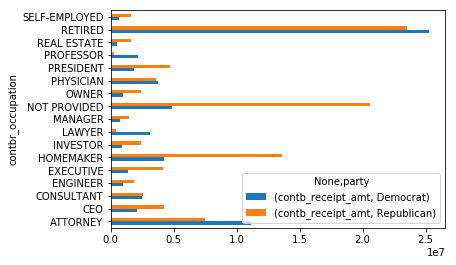

In [89]:
df_party_occ.plot(kind='barh')

可以看到，HOMEMARKER更倾向于Republiican；

#### 对Obama和Romney总出资额最高的职业和企业

##### 出资最多的职业

In [90]:
df_bo_mr[df_bo_mr.cand_nm=='Obama, Barack'].groupby(['contbr_occupation']).contb_receipt_amt.apply(np.sum).sort_values()[-3:]

contbr_occupation
INFORMATION REQUESTED     4866973.96
ATTORNEY                 11141982.97
RETIRED                  25305116.38
Name: contb_receipt_amt, dtype: float64

In [91]:
df_bo_mr[df_bo_mr.cand_nm=='Romney, Mitt'].groupby(['contbr_occupation']).contb_receipt_amt.apply(np.sum).sort_values()[-3:]

contbr_occupation
HOMEMAKER                                  8147446.22
INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
RETIRED                                   11508473.59
Name: contb_receipt_amt, dtype: float64

##### 出资最多的企业

In [92]:
df_bo_mr[df_bo_mr.cand_nm=='Obama, Barack'].groupby(['contbr_employer']).contb_receipt_amt.apply(np.sum).sort_values()[-3:]

contbr_employer
NOT EMPLOYED      8586308.70
SELF-EMPLOYED    17080985.96
RETIRED          22694358.85
Name: contb_receipt_amt, dtype: float64

In [93]:
df_bo_mr[df_bo_mr.cand_nm=='Romney, Mitt'].groupby(['contbr_employer']).contb_receipt_amt.apply(np.sum).sort_values()[-3:]

contbr_employer
HOMEMAKER                                  8147196.22
RETIRED                                   11506225.71
INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
Name: contb_receipt_amt, dtype: float64

### 对出资额分组

对该数据做另一种非常实用的分析:利用**cut**函数根据**出资额**的大小将**数据离散化**到多个面元中；

#### 分析二者投资者的投资额度分布

In [109]:
factor = pd.cut(df_bo_mr.contb_receipt_amt, [0,1,10,100,1000,10000,100000])
df_bo_mr.groupby(['cand_nm',factor]).size()

cand_nm        contb_receipt_amt
Obama, Barack  (0, 1]                  493
               (1, 10]               40070
               (10, 100]            372280
               (100, 1000]          153991
               (1000, 10000]         22284
               (10000, 100000]           2
Romney, Mitt   (0, 1]                   77
               (1, 10]                3681
               (10, 100]             31853
               (100, 1000]           43357
               (1000, 10000]         26186
               (10000, 100000]           1
dtype: int64

In [115]:
df_bo_mr.groupby(['cand_nm',factor]).contb_receipt_amt.sum().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00


#### 绘图观察

In [116]:
bucket_sums = df_bo_mr.groupby(['cand_nm',factor]).contb_receipt_amt.sum().unstack(0)
normal_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normal_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880


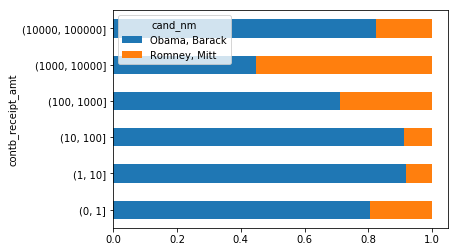

In [119]:
normal_sums.plot(kind='barh', stacked=True)

可以看到：在小额赞助中，奥观海远远高于对手；

### 根据州统计赞助信息

#### 根据候选人，州分组

In [141]:
grouped = df_bo_mr.groupby(['cand_nm','contbr_st'])
grouped.sum().unstack().fillna(0)

contb_receipt_amt                                          \
contbr_st                    AA      AB        AE         AK         AL   
cand_nm                                                                   
Obama, Barack           56405.0  2048.0  42973.75  281840.15  543123.48   
Romney, Mitt              135.0     0.0   5680.00   86204.24  527303.51   

                                                                    \
contbr_st           AP         AR      AS          AZ           CA   
cand_nm                                                              
Obama, Barack  37130.5  359247.28  2955.0  1506476.98  23824984.24   
Romney, Mitt    1655.0  105556.00     0.0  1888436.23  11237636.60   

                  ...          file_num                             \
contbr_st         ...                UT            VA           VI   
cand_nm           ...                                                
Obama, Barack     ...      2.158762e+09  1.662582e+10  320768906.0   
Romney, Mitt      ...      5.433571e+09  3.313021e+09    1532175.0   

                                                                       \
contbr_st                VT            WA            WI            WV   
cand_nm                                                                 
Obama, Barack  2.769653e+09  1.611548e+10  6.237224e+09  1.031333e+09   
Romney, Mitt   1.044937e+08  1.827046e+09  5.525210e+08  1.558537e+08   

                                                     
contbr_st               WY           XX          ZZ  
cand_nm                                              
Obama, Barack  817247010.0          0.0  11614751.0  
Romney, Mitt   294092129.0  181155469.0         0.0  

[2 rows x 134 columns]

#### 保留资助额字段，计算所占各候选人在当前州所占资助比例

In [161]:
grouped_sum = grouped.contb_receipt_amt.sum().unstack().fillna(0)
grouped_sum = grouped_sum.div(grouped_sum.sum(0),1)
grouped_sum

contbr_st,AA,AB,AE,AK,AL,AP,AR,AS,AZ,CA,...,UT,VA,VI,VT,WA,WI,WV,WY,XX,ZZ
cand_nm,,,,,,,,,,,,,,,,,,,,,
"Obama, Barack",0.997612,1.0,0.883257,0.765778,0.50739,0.957329,0.772902,1.0,0.443745,0.679498,...,0.122689,0.5514,0.958438,0.946983,0.760119,0.806982,0.5717,0.434456,0.0,1.0
"Romney, Mitt",0.002388,0.0,0.116743,0.234222,0.49261,0.042671,0.227098,0.0,0.556255,0.320502,...,0.877311,0.4486,0.041562,0.053017,0.239881,0.193018,0.4283,0.565544,1.0,0.0


#### 柱状图绘制

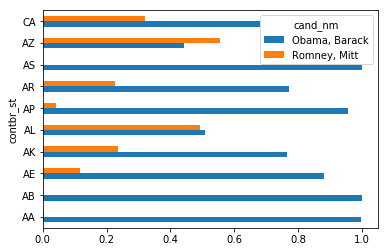

In [166]:
grouped_sum.stack().unstack(0)[:10].plot(kind='barh')

#### basemap地图绘制 -- so cool man!!!

In [180]:
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
from matplotlib.collections import LineCollection
import shapefile as ShapeFile
from dbfread import DBF

TypeError: 'module' object is not callable

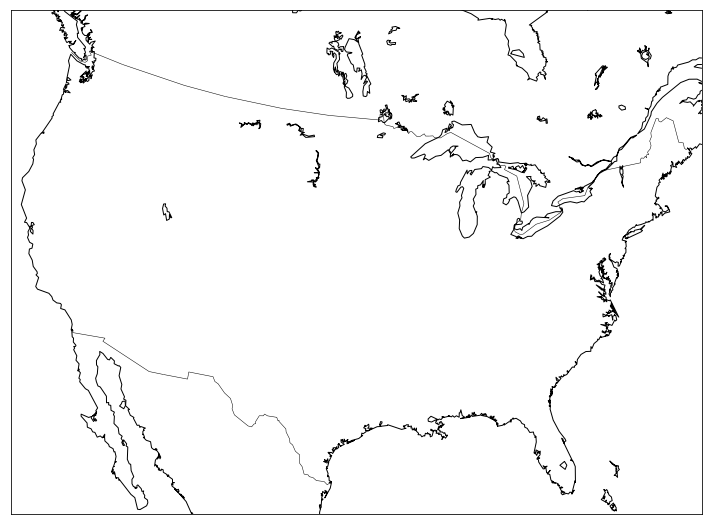

In [186]:
obama = grouped_sum.stack().unstack(0)['Obama, Barack']

fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

lllat = 21; urlat = 53; lllon = -118; urlon = -62

m = Basemap(ax=ax, projection='stere',
            lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
            llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon,
            urcrnrlon=urlon, resolution='l')
m.drawcoastlines()
m.drawcountries()

shp = ShapeFile('../states/statesp020') # 找不到数据啊
dbf = DBF('../states/statesp020') # 找不到数据啊

for npoly in range(shp.info()[0]):
    # 在地图上绘制彩色多边形
    shpsegs = []
    shp_object = shp.read_object(npoly)
    verts = shp_object.vertices()
    rings = len(verts)
    for ring in range(rings):
        lons, lats = zip(*verts[ring])
        x, y = m(lons, lats)
        shpsegs.append(zip(x,y))
        if ring == 0:
            shapedict = dbf.read_record(npoly)
        name = shapedict['STATE']
    lines = LineCollection(shpsegs,antialiaseds=(1,))
    
    # state_to_code字典,例如'ALASKA' -> 'AK', omitted
    try:
        per = obama[state_to_code[name.upper()]]
    except KeyError:
        continue
    
    lines.set_facecolors('k')
    lines.set_alpha(0.75 * per) # 把“百分比”变小一点
    lines.set_edgecolors('k')
    lines.set_linewidth(0.3)
plt.show()

## alert

### df['a']跟df[['a']]的区别

In [95]:
_df = DataFrame({'a':[12,23,34],'b':[11,22,33]})

#### df['a']

In [96]:
_df['a']

0    12
1    23
2    34
Name: a, dtype: int64

#### df[['a']]

In [97]:
_df[['a']]

,a
0,12
1,23
2,34


In [98]:
_df[['a','b']]

,a,b
0,12,11
1,23,22
2,34,33


#### 小结

* df['a']：
    * 得到一个由指定列名的Series；
    * 不能指定多个列，因为多个列无法对应一个Series；
    * 获取原DataFrame的某一列组成的低一个维度的数据；
* df[['a']]：
    * 得到一个DataFrame的子集，但是依然是DataFrame；
    * 可以指定多个，因为本身是DataFrame可以有多列；
    * 维度不变，获取指定的N个列组成的数据；